In [2]:
import gymnasium as gym
import mujoco
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import gymnasium_robotics
import time
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import copy
#from stable_baselines3 import SAC
#from stable_baselines3.her import HERReplayBuffer

import matplotlib.pyplot as plt

In [2]:
gym.__version__

'1.0.0'

### CHECKING THE GYM

In [3]:
# Create the FetchReach environment
env = gym.make("FetchReach-v3")

# Reset the environment to initialize it
observation, info = env.reset()

# Perform a random action
action = env.action_space.sample()  # Replace with your custom action if needed
next_observation, reward, terminated, truncated, info = env.step(action)

# Print some information
print("Initial Observation:", observation)
print("Action:", action)
print("Next Observation:", next_observation)
print("Reward:", reward)
print("Terminated:", terminated)
print("Truncated:", truncated)
print("Info:", info)

# Close the environment
env.close()

Initial Observation: {'observation': array([1.4349, 0.2641, 0.786 , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    ]), 'achieved_goal': array([1.4349, 0.2641, 0.786 ]), 'desired_goal': array([0.78939379, 0.24836739, 0.64171718])}
Action: [ 0.20583607  0.03450347  0.51969004 -0.2541982 ]
Next Observation: {'observation': array([ 1.40363986e+00,  2.65178162e-01,  7.93228379e-01,  0.00000000e+00,
        0.00000000e+00, -3.24293265e-02,  7.73044153e-04,  5.74447679e-03,
        2.12292113e-05,  1.72713852e-05]), 'achieved_goal': array([1.40363986, 0.26517816, 0.79322838]), 'desired_goal': array([0.78939379, 0.24836739, 0.64171718])}
Reward: -1.0
Terminated: False
Truncated: False
Info: {'is_success': 0.0}


In [4]:
"""# Initialize environment and agent

env = gym.make("FetchReach-v3")
obs_dim = env.observation_space["observation"].shape[0]
goal_dim = env.observation_space["desired_goal"].shape[0]
action_dim = env.action_space.shape[0]

# Initialize buffer and agent with proper dimensions
buffer = HERReplayBuffer(100000, obs_dim, action_dim, goal_dim)
agent = SACAgent(obs_dim, goal_dim, action_dim, reward_scale=10.0)  # Example value


# Training loop
for episode in range(1000):
    obs_dict, _ = env.reset()
    trajectory = []  # To store the episode transitions
    done = False

    while not done:
        obs = obs_dict["observation"]
        goal = obs_dict["desired_goal"]
        achieved_goal = obs_dict["achieved_goal"]

        action = agent.select_action(obs, goal)
        next_obs_dict, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        trajectory.append((obs, action, next_obs_dict["observation"], goal, achieved_goal, done))
        obs_dict = next_obs_dict

    # Add trajectory with HER relabeling
    buffer.add_episode(trajectory)

    # Training updates
    if buffer.size >= 1000:
        for _ in range(50):  # Perform 50 updates per episode
            batch = buffer.sample(64)
            agent.train(*batch)

    # Evaluation
    if episode % 10 == 0:
        success_rate = evaluate_agent(env, agent, num_episodes=5)
        print(f"Episode {episode}, Success Rate: {success_rate:.2f}") """


'# Initialize environment and agent\n\nenv = gym.make("FetchReach-v3")\nobs_dim = env.observation_space["observation"].shape[0]\ngoal_dim = env.observation_space["desired_goal"].shape[0]\naction_dim = env.action_space.shape[0]\n\n# Initialize buffer and agent with proper dimensions\nbuffer = HERReplayBuffer(100000, obs_dim, action_dim, goal_dim)\nagent = SACAgent(obs_dim, goal_dim, action_dim, reward_scale=10.0)  # Example value\n\n\n# Training loop\nfor episode in range(1000):\n    obs_dict, _ = env.reset()\n    trajectory = []  # To store the episode transitions\n    done = False\n\n    while not done:\n        obs = obs_dict["observation"]\n        goal = obs_dict["desired_goal"]\n        achieved_goal = obs_dict["achieved_goal"]\n\n        action = agent.select_action(obs, goal)\n        next_obs_dict, reward, terminated, truncated, info = env.step(action)\n        done = terminated or truncated\n\n        trajectory.append((obs, action, next_obs_dict["observation"], goal, achieved

### SAC ALGORITHM

In [3]:
# ------------------------------------------------------------
# Actor-Critic Neural Networks for Soft Actor-Critic (SAC)
# ------------------------------------------------------------
class PolicyNetwork(nn.Module):
    """
    Actor (Policy) Network for SAC.
    
    Purpose:
    - Maps the current state and goal to the parameters of a Gaussian distribution.
    - Produces the mean and log standard deviation (log_std) for action sampling.

    Input:
    - state_dim: Dimension of the environment's state space.
    - goal_dim: Dimension of the goal space.
    - action_dim: Dimension of the action space.
    - hidden_units: Number of neurons in hidden layers (default: 256).

    Output:
    - mean: Mean of the Gaussian distribution.
    - log_std: Logarithm of standard deviation (clamped for numerical stability).
    """

    def __init__(self, state_dim, goal_dim, action_dim, hidden_units=256):
        super(PolicyNetwork, self).__init__()
        # First hidden layer: Combines state and goal as input
        self.fc1 = nn.Linear(state_dim + goal_dim, hidden_units)
        # Second hidden layer
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        # Outputs the mean of the action distribution
        self.mean_layer = nn.Linear(hidden_units, action_dim)
        # Outputs the log of the standard deviation
        self.log_std_layer = nn.Linear(hidden_units, action_dim)

    def forward(self, state, goal):
        """
        Forward pass: Combines state and goal, passes through the network.
        
        Returns:
        - mean: Action mean (used for sampling and evaluation).
        - log_std: Logarithmic standard deviation (clamped for stability).
        """
        input_data = torch.cat([state, goal], dim=-1)  # Concatenate state and goal
        x = F.relu(self.fc1(input_data))  # Apply ReLU activation to the first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        mean = self.mean_layer(x)  # Compute mean
        log_std = torch.clamp(self.log_std_layer(x), -20, 2)  # Clamp log_std for stability
        return mean, log_std

    def sample_action(self, state, goal):
        """
        Samples an action from the policy using the reparameterization trick.

        Returns:
        - action: Tanh-transformed action (bounded between -1 and 1).
        - log_prob: Log probability of the sampled action.
        - mean: Mean of the action distribution.
        - log_std: Logarithmic standard deviation of the action distribution.
        """
        mean, log_std = self.forward(state, goal)  # Compute mean and log_std
        std = torch.exp(log_std)  # Convert log_std to standard deviation
        noise = torch.randn_like(mean)  # Generate noise for reparameterization
        pre_tanh_action = mean + std * noise  # Sample action before applying Tanh
        action = torch.tanh(pre_tanh_action)  # Apply Tanh to bound action

        # Compute log probability, accounting for the Tanh transformation
        log_prob = -0.5 * ((noise ** 2) + 2 * log_std + np.log(2 * np.pi))
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        log_prob -= torch.sum(torch.log(1 - action.pow(2) + 1e-6), dim=-1, keepdim=True)
        return action, log_prob, mean, log_std


class QNetwork(nn.Module):
    """
    Critic (Q-Value) Network for SAC.
    
    Purpose:
    - Estimates the Q-value for a given state, goal, and action.
    - Used to evaluate the quality of actions chosen by the actor.

    Input:
    - state_dim: Dimension of the environment's state space.
    - goal_dim: Dimension of the goal space.
    - action_dim: Dimension of the action space.
    - hidden_units: Number of neurons in hidden layers (default: 256).

    Output:
    - Q-value: Scalar value representing the expected future reward.
    """

    def __init__(self, state_dim, goal_dim, action_dim, hidden_units=256):
        super(QNetwork, self).__init__()
        # First hidden layer: Combines state, goal, and action as input
        self.fc1 = nn.Linear(state_dim + goal_dim + action_dim, hidden_units)
        # Second hidden layer
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        # Final layer outputs the Q-value
        self.fc3 = nn.Linear(hidden_units, 1)

    def forward(self, state, goal, action):
        """
        Forward pass: Combines state, goal, and action, passes through the network.
        
        Returns:
        - Q-value estimate.
        """
        input_data = torch.cat([state, goal, action], dim=-1)  # Concatenate inputs
        x = F.relu(self.fc1(input_data))  # Apply ReLU activation to the first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        return self.fc3(x)  # Output Q-value


# ------------------------------------------------------------
# Hindsight Experience Replay Buffer
# ------------------------------------------------------------
class HERBuffer:
    """
    Replay Buffer for storing and sampling transitions with HER.

    Purpose:
    - Store environment transitions (state, goal, action, reward, next state, done).
    - Allow efficient sampling for training.
    - Support relabeling with HER (adding new goals to transitions).

    Attributes:
    - capacity: Maximum number of transitions the buffer can store.
    - states, goals, actions, rewards, next_states, dones: Arrays to store transitions.
    - ptr: Pointer to the next position for storing a transition.
    - size: Current number of stored transitions.
    """

    def __init__(self, state_dim, goal_dim, action_dim, capacity=1_000_000):
        self.capacity = capacity  # Maximum buffer size
        self.ptr = 0  # Pointer for the next position to store a transition
        self.size = 0  # Number of transitions currently stored

        # Preallocate memory for transitions
        self.states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.goals = np.zeros((capacity, goal_dim), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.dones = np.zeros((capacity, 1), dtype=np.float32)

    def store(self, state, goal, action, reward, next_state, done):
        """
        Store a single transition in the buffer.

        Parameters:
        - state: Current state.
        - goal: Desired goal.
        - action: Action taken by the agent.
        - reward: Reward received after taking the action.
        - next_state: State observed after the action.
        - done: Whether the episode ended after this transition.
        """
        idx = self.ptr % self.capacity  # Compute the index for storing the transition
        self.states[idx] = state
        self.goals[idx] = goal
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done

        self.ptr += 1  # Move the pointer to the next position
        self.size = min(self.size + 1, self.capacity)  # Update buffer size

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions for training.

        Parameters:
        - batch_size: Number of transitions to sample.

        Returns:
        - Tuple of sampled (states, goals, actions, rewards, next_states, dones).
        """
        indices = np.random.randint(0, self.size, size=batch_size)  # Random indices
        return (
            self.states[indices],
            self.goals[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices],
        )


### SAC WITH HER

In [4]:
# ------------------------------------------------------------
# SAC Agent with HER
# ------------------------------------------------------------
class SACWithHER:
    """
    Combines Soft Actor-Critic (SAC) with Hindsight Experience Replay (HER).

    Purpose:
    - Implements an agent that learns from sparse rewards using SAC and HER.
    - SAC is used for policy optimization, and HER relabels goals to improve sample efficiency.

    Parameters:
    - state_dim: Dimension of the environment's state space.
    - goal_dim: Dimension of the goal space.
    - action_dim: Dimension of the action space.
    - lr: Learning rate for optimizers.
    - gamma: Discount factor for future rewards.
    - tau: Soft update factor for target networks.
    - alpha: Temperature parameter for SAC (controls exploration-exploitation).
    - buffer_capacity: Maximum size of the replay buffer.
    - her_future_k: Future step range for HER goal relabeling.
    - her_ratio: Fraction of transitions to relabel using HER.
    - device: Device to use for computations ('cuda' or 'cpu').
    """

    def __init__(self, state_dim, goal_dim, action_dim, lr=3e-4, gamma=0.98, tau=0.005, alpha=0.2,
                 buffer_capacity=1_000_000, her_future_k=4, her_ratio=0.8, device='cuda'):
        self.device = device  # Compute device
        self.gamma = gamma  # Discount factor for future rewards
        self.tau = tau  # Soft update coefficient
        self.alpha = alpha  # SAC exploration parameter
        self.her_future_k = her_future_k  # Range for future goals in HER
        self.her_ratio = her_ratio  # Fraction of HER relabeled transitions

        # Initialize networks
        self.actor = PolicyNetwork(state_dim, goal_dim, action_dim).to(device)
        self.critic1 = QNetwork(state_dim, goal_dim, action_dim).to(device)
        self.critic2 = QNetwork(state_dim, goal_dim, action_dim).to(device)
        self.critic1_target = copy.deepcopy(self.critic1)
        self.critic2_target = copy.deepcopy(self.critic2)

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=lr)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=lr)

        # Replay buffer for transitions and HER
        self.replay_buffer = HERBuffer(state_dim, goal_dim, action_dim, capacity=buffer_capacity)

    def choose_action(self, state, goal, eval_mode=False):
        """
        Select an action given the current state and goal.

        Parameters:
        - state: Current environment observation.
        - goal: Desired goal for the task.
        - eval_mode: Whether to use a deterministic policy (default: False).

        Returns:
        - Selected action as a NumPy array.
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        goal_tensor = torch.FloatTensor(goal).unsqueeze(0).to(self.device)

        with torch.no_grad():
            # Sample action using the actor network
            action, _, mean, _ = self.actor.sample_action(state_tensor, goal_tensor)

        if eval_mode:
            # Use deterministic action (mean) if evaluation mode is active
            action = torch.tanh(mean)

        return action.cpu().numpy()[0]  # Convert action to NumPy for compatibility with the environment

    def update_networks(self, batch_size):
        """
        Update the SAC networks using a batch of transitions from the replay buffer.

        Parameters:
        - batch_size: Number of transitions to sample from the buffer.
        """
        if self.replay_buffer.size < batch_size:
            return  # Wait until the buffer has enough data

        # Sample a batch of transitions
        states, goals, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states).to(self.device)
        goals = torch.FloatTensor(goals).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Compute target Q-value
        with torch.no_grad():
            next_actions, next_log_probs, _, _ = self.actor.sample_action(next_states, goals)
            target_q = torch.min(
                self.critic1_target(next_states, goals, next_actions),
                self.critic2_target(next_states, goals, next_actions)
            ) - self.alpha * next_log_probs
            target_q = rewards + (1 - dones) * self.gamma * target_q

        # Update critic networks
        current_q1 = self.critic1(states, goals, actions)
        current_q2 = self.critic2(states, goals, actions)

        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        # Update actor network
        new_actions, log_probs, _, _ = self.actor.sample_action(states, goals)
        q_new_action = torch.min(
            self.critic1(states, goals, new_actions),
            self.critic2(states, goals, new_actions)
        )
        actor_loss = (self.alpha * log_probs - q_new_action).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Perform soft update of target networks
        for param, target_param in zip(self.critic1.parameters(), self.critic1_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.critic2.parameters(), self.critic2_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def relabel_with_her(self, episode_transitions):
        """
        Relabel transitions using Hindsight Experience Replay (HER).

        Parameters:
        - episode_transitions: List of transitions from a single episode.
          Each transition is a tuple (state, goal, action, reward, next_state, done).
        """
        achieved_goals = [trans[4][:3] for trans in episode_transitions]  # Extract achieved goals
        num_her_samples = int(self.her_ratio * len(episode_transitions))  # Number of HER relabeled transitions

        for _ in range(num_her_samples):
            idx = np.random.randint(len(episode_transitions))
            future_idx = np.random.randint(idx, min(idx + self.her_future_k, len(episode_transitions)))
            new_goal = achieved_goals[future_idx]  # Pick a future achieved goal

            state, old_goal, action, reward, next_state, done = episode_transitions[idx]
            dist = np.linalg.norm(next_state[:3] - new_goal)  # Distance to new goal
            new_reward = 0.0 if dist < 0.05 else -1.0  # Relabel reward
            new_done = 1.0 if dist < 0.05 else 0.0  # Relabel done flag

            # Store relabeled transition in the replay buffer
            self.replay_buffer.store(state, new_goal, action, new_reward, next_state, new_done)

        # Store original transitions as well
        for transition in episode_transitions:
            self.replay_buffer.store(*transition)


### EVALUATION AND TRANING (To obtain the plots run the 6 seeds plot version one)

In [5]:
# ------------------------------------------------------------
# Evaluation Function
# ------------------------------------------------------------
def evaluate_policy(agent, environment, num_episodes=10, render_mode=False):
    """
    Test the agent's performance over several episodes.

    Returns the proportion of successful episodes, defined by
    the environment's success criteria.
    """
    success_count = 0
    for episode in range(num_episodes):
        obs_dict = environment.reset()[0]
        observation, desired_goal = obs_dict['observation'], obs_dict['desired_goal']
        done = False

        while not done:
            action = agent.choose_action(observation, desired_goal, eval_mode=True)
            obs_dict, reward, terminated, truncated, info = environment.step(action)
            observation = obs_dict['observation']
            done = terminated or truncated

        if info.get('is_success', 0.0) >= 0.5:
            success_count += 1

    return success_count / num_episodes



# For 1 seed iteration

In [6]:


# ------------------------------------------------------------
# Training Loop
# ------------------------------------------------------------
if __name__ == "__main__":
    # Initialize the environment
    env = gym.make('FetchReach-v3', max_episode_steps=50)

    # Extract dimensions of observations, goals, and actions
    observation_dim = env.reset()[0]['observation'].shape[0]
    goal_dim = env.reset()[0]['desired_goal'].shape[0]
    action_dim = env.action_space.shape[0]

    # Hyperparameters
    learning_rate = 3e-4
    discount_factor = 0.98
    soft_update_tau = 0.005
    temperature_alpha = 0.2
    buffer_capacity = 1_000_000
    max_training_episodes = 5000
    max_steps_per_episode = 50
    batch_size = 256
    her_future_k = 4
    her_sample_ratio = 0.8
    eval_interval = 100

    # Create the SAC agent with HER
    sac_her_agent = SACWithHER(
        observation_dim, goal_dim, action_dim, lr=learning_rate, gamma=discount_factor,
        tau=soft_update_tau, alpha=temperature_alpha, buffer_capacity=buffer_capacity,
        her_future_k=her_future_k, her_ratio=her_sample_ratio, device='cuda'
    )

    for episode in range(max_training_episodes):
        # Reset the environment for a new episode
        obs_dict = env.reset()[0]
        current_obs, desired_goal = obs_dict['observation'], obs_dict['desired_goal']
        episode_memory = []
        episode_success = 0
        done = False

        for step in range(max_steps_per_episode):
            # Agent selects an action
            action = sac_her_agent.choose_action(current_obs, desired_goal, eval_mode=False)

            # Environment processes the action
            next_obs_dict, reward, terminated, truncated, info = env.step(action)
            next_obs = next_obs_dict['observation']
            done = terminated or truncated

            # Track success for this episode
            if info.get('is_success', 0.0) >= 0.5:
                episode_success = 1

            # Store transition in memory
            episode_memory.append((current_obs, desired_goal, action, reward, next_obs, float(done)))
            current_obs = next_obs

            # Update the SAC agent's parameters
            sac_her_agent.update_networks(batch_size)

            if done:
                break

        # Perform HER relabeling and store in buffer
        sac_her_agent.relabel_with_her(episode_memory)

        print(f"Episode {episode + 1}: Success = {episode_success}")

        # Evaluate the agent periodically
        if (episode + 1) % eval_interval == 0:
            success_rate = evaluate_policy(sac_her_agent, env, num_episodes=10, render_mode=False)
            print(f"Evaluation after {episode + 1} episodes: Success rate = {success_rate * 100:.2f}%")
            if success_rate >= 0.95:
                print("Agent reached >95% success rate. Stopping training early.")
                break

    # Final evaluation
    final_success_rate = evaluate_policy(sac_her_agent, env, num_episodes=100, render_mode=False)
    print(f"Final evaluation: Success rate = {final_success_rate * 100:.2f}%")


Episode 1: Success = 0
Episode 2: Success = 0
Episode 3: Success = 0
Episode 4: Success = 0
Episode 5: Success = 0
Episode 6: Success = 0
Episode 7: Success = 0
Episode 8: Success = 1
Episode 9: Success = 0
Episode 10: Success = 0
Episode 11: Success = 0
Episode 12: Success = 0
Episode 13: Success = 0
Episode 14: Success = 0
Episode 15: Success = 0
Episode 16: Success = 0
Episode 17: Success = 0
Episode 18: Success = 0
Episode 19: Success = 0
Episode 20: Success = 0
Episode 21: Success = 0
Episode 22: Success = 0
Episode 23: Success = 1
Episode 24: Success = 0
Episode 25: Success = 0
Episode 26: Success = 0
Episode 27: Success = 0
Episode 28: Success = 0
Episode 29: Success = 0
Episode 30: Success = 0
Episode 31: Success = 0
Episode 32: Success = 0
Episode 33: Success = 0
Episode 34: Success = 0
Episode 35: Success = 0
Episode 36: Success = 1
Episode 37: Success = 0
Episode 38: Success = 0
Episode 39: Success = 1
Episode 40: Success = 0
Episode 41: Success = 0
Episode 42: Success = 0
E

# For 6 seed iterations

In [27]:
# ------------------------------------------------------------
# Training Loop with Multiple Seeds for Robustness
# ------------------------------------------------------------
if __name__ == "__main__":
    seeds = [42, 123, 2023, 7, 77, 999]  # Random seeds for robustness
    env_name = 'FetchReach-v3'
    max_training_episodes = 5000
    max_steps_per_episode = 50
    batch_size = 256
    eval_interval = 100
    num_eval_episodes = 10  # Number of evaluation episodes
    final_eval_episodes = 100  # Number of final evaluation episodes

    # To store success rates for all seeds
    all_success_rates = []

    for seed in seeds:
        print(f"Running with seed: {seed}")

        # Create environment and set random seeds
        env = gym.make(env_name, max_episode_steps=max_steps_per_episode)
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

        # Extract dimensions of observations, goals, and actions
        observation_dim = env.reset()[0]['observation'].shape[0]
        goal_dim = env.reset()[0]['desired_goal'].shape[0]
        action_dim = env.action_space.shape[0]

        # Hyperparameters
        learning_rate = 3e-4
        discount_factor = 0.98
        soft_update_tau = 0.005
        temperature_alpha = 0.2
        buffer_capacity = 1_000_000
        her_future_k = 4
        her_sample_ratio = 0.8

        # Initialize SAC with HER agent
        sac_her_agent = SACWithHER(
            observation_dim, goal_dim, action_dim, lr=learning_rate, gamma=discount_factor,
            tau=soft_update_tau, alpha=temperature_alpha, buffer_capacity=buffer_capacity,
            her_future_k=her_future_k, her_ratio=her_sample_ratio, device='cuda'
        )

        # Training loop for the current seed
        for episode in range(max_training_episodes):
            # Reset the environment for a new episode
            obs_dict = env.reset()[0]
            current_obs, desired_goal = obs_dict['observation'], obs_dict['desired_goal']
            episode_memory = []
            episode_success = 0
            done = False

            for step in range(max_steps_per_episode):
                # Agent selects an action
                action = sac_her_agent.choose_action(current_obs, desired_goal, eval_mode=False)

                # Environment processes the action
                next_obs_dict, reward, terminated, truncated, info = env.step(action)
                next_obs = next_obs_dict['observation']
                done = terminated or truncated

                # Track success for this episode
                if info.get('is_success', 0.0) >= 0.5:
                    episode_success = 1

                # Store transition in memory
                episode_memory.append((current_obs, desired_goal, action, reward, next_obs, float(done)))
                current_obs = next_obs

                # Update the SAC agent's parameters
                sac_her_agent.update_networks(batch_size)

                if done:
                    break

            # Perform HER relabeling and store in buffer
            sac_her_agent.relabel_with_her(episode_memory)

            print(f"Seed {seed}, Episode {episode + 1}: Success = {episode_success}")

            # Evaluate the agent periodically
            if (episode + 1) % eval_interval == 0:
                success_rate = evaluate_policy(sac_her_agent, env, num_episodes=num_eval_episodes, render_mode=False)
                print(f"Seed {seed}, Evaluation after {episode + 1} episodes: Success rate = {success_rate * 100:.2f}%")
                if success_rate >= 0.95:
                    print(f"Seed {seed}: Agent reached >95% success rate. Stopping training early.")
                    break

        # Final evaluation for the current seed
        final_success_rate = evaluate_policy(sac_her_agent, env, num_episodes=final_eval_episodes, render_mode=False)
        print(f"Seed {seed}: Final evaluation success rate = {final_success_rate * 100:.2f}%")
        all_success_rates.append(final_success_rate)

    # Compute and display average success rate across seeds
    avg_success_rate = np.mean(all_success_rates)
    print(f"Average success rate across seeds: {avg_success_rate * 100:.2f}%")


Running with seed: 42
Seed 42, Episode 1: Success = 0
Seed 42, Episode 2: Success = 0
Seed 42, Episode 3: Success = 0
Seed 42, Episode 4: Success = 0
Seed 42, Episode 5: Success = 0
Seed 42, Episode 6: Success = 0
Seed 42, Episode 7: Success = 0
Seed 42, Episode 8: Success = 0
Seed 42, Episode 9: Success = 0
Seed 42, Episode 10: Success = 0
Seed 42, Episode 11: Success = 0
Seed 42, Episode 12: Success = 0
Seed 42, Episode 13: Success = 0
Seed 42, Episode 14: Success = 0
Seed 42, Episode 15: Success = 0
Seed 42, Episode 16: Success = 0
Seed 42, Episode 17: Success = 0
Seed 42, Episode 18: Success = 0
Seed 42, Episode 19: Success = 0
Seed 42, Episode 20: Success = 0
Seed 42, Episode 21: Success = 0
Seed 42, Episode 22: Success = 0
Seed 42, Episode 23: Success = 0
Seed 42, Episode 24: Success = 0
Seed 42, Episode 25: Success = 0
Seed 42, Episode 26: Success = 1
Seed 42, Episode 27: Success = 0
Seed 42, Episode 28: Success = 0
Seed 42, Episode 29: Success = 0
Seed 42, Episode 30: Success =

Seed 123, Episode 38: Success = 0
Seed 123, Episode 39: Success = 0
Seed 123, Episode 40: Success = 0
Seed 123, Episode 41: Success = 0
Seed 123, Episode 42: Success = 0
Seed 123, Episode 43: Success = 0
Seed 123, Episode 44: Success = 0
Seed 123, Episode 45: Success = 1
Seed 123, Episode 46: Success = 0
Seed 123, Episode 47: Success = 0
Seed 123, Episode 48: Success = 0
Seed 123, Episode 49: Success = 0
Seed 123, Episode 50: Success = 0
Seed 123, Episode 51: Success = 0
Seed 123, Episode 52: Success = 0
Seed 123, Episode 53: Success = 1
Seed 123, Episode 54: Success = 0
Seed 123, Episode 55: Success = 0
Seed 123, Episode 56: Success = 0
Seed 123, Episode 57: Success = 1
Seed 123, Episode 58: Success = 0
Seed 123, Episode 59: Success = 0
Seed 123, Episode 60: Success = 0
Seed 123, Episode 61: Success = 1
Seed 123, Episode 62: Success = 0
Seed 123, Episode 63: Success = 0
Seed 123, Episode 64: Success = 0
Seed 123, Episode 65: Success = 0
Seed 123, Episode 66: Success = 0
Seed 123, Epis

Seed 2023, Episode 67: Success = 1
Seed 2023, Episode 68: Success = 0
Seed 2023, Episode 69: Success = 0
Seed 2023, Episode 70: Success = 0
Seed 2023, Episode 71: Success = 1
Seed 2023, Episode 72: Success = 0
Seed 2023, Episode 73: Success = 1
Seed 2023, Episode 74: Success = 1
Seed 2023, Episode 75: Success = 1
Seed 2023, Episode 76: Success = 1
Seed 2023, Episode 77: Success = 0
Seed 2023, Episode 78: Success = 0
Seed 2023, Episode 79: Success = 0
Seed 2023, Episode 80: Success = 0
Seed 2023, Episode 81: Success = 0
Seed 2023, Episode 82: Success = 0
Seed 2023, Episode 83: Success = 1
Seed 2023, Episode 84: Success = 0
Seed 2023, Episode 85: Success = 1
Seed 2023, Episode 86: Success = 0
Seed 2023, Episode 87: Success = 1
Seed 2023, Episode 88: Success = 1
Seed 2023, Episode 89: Success = 0
Seed 2023, Episode 90: Success = 0
Seed 2023, Episode 91: Success = 0
Seed 2023, Episode 92: Success = 1
Seed 2023, Episode 93: Success = 1
Seed 2023, Episode 94: Success = 0
Seed 2023, Episode 9

Seed 7, Episode 100: Success = 1
Seed 7, Evaluation after 100 episodes: Success rate = 0.00%
Seed 7, Episode 101: Success = 1
Seed 7, Episode 102: Success = 1
Seed 7, Episode 103: Success = 1
Seed 7, Episode 104: Success = 1
Seed 7, Episode 105: Success = 1
Seed 7, Episode 106: Success = 1
Seed 7, Episode 107: Success = 1
Seed 7, Episode 108: Success = 1
Seed 7, Episode 109: Success = 1
Seed 7, Episode 110: Success = 1
Seed 7, Episode 111: Success = 1
Seed 7, Episode 112: Success = 1
Seed 7, Episode 113: Success = 1
Seed 7, Episode 114: Success = 1
Seed 7, Episode 115: Success = 1
Seed 7, Episode 116: Success = 1
Seed 7, Episode 117: Success = 1
Seed 7, Episode 118: Success = 1
Seed 7, Episode 119: Success = 1
Seed 7, Episode 120: Success = 1
Seed 7, Episode 121: Success = 0
Seed 7, Episode 122: Success = 1
Seed 7, Episode 123: Success = 1
Seed 7, Episode 124: Success = 1
Seed 7, Episode 125: Success = 1
Seed 7, Episode 126: Success = 1
Seed 7, Episode 127: Success = 1
Seed 7, Episode 

Seed 77, Episode 138: Success = 1
Seed 77, Episode 139: Success = 1
Seed 77, Episode 140: Success = 1
Seed 77, Episode 141: Success = 1
Seed 77, Episode 142: Success = 1
Seed 77, Episode 143: Success = 1
Seed 77, Episode 144: Success = 1
Seed 77, Episode 145: Success = 1
Seed 77, Episode 146: Success = 1
Seed 77, Episode 147: Success = 1
Seed 77, Episode 148: Success = 1
Seed 77, Episode 149: Success = 1
Seed 77, Episode 150: Success = 1
Seed 77, Episode 151: Success = 1
Seed 77, Episode 152: Success = 1
Seed 77, Episode 153: Success = 1
Seed 77, Episode 154: Success = 1
Seed 77, Episode 155: Success = 1
Seed 77, Episode 156: Success = 1
Seed 77, Episode 157: Success = 1
Seed 77, Episode 158: Success = 1
Seed 77, Episode 159: Success = 1
Seed 77, Episode 160: Success = 1
Seed 77, Episode 161: Success = 1
Seed 77, Episode 162: Success = 1
Seed 77, Episode 163: Success = 1
Seed 77, Episode 164: Success = 1
Seed 77, Episode 165: Success = 1
Seed 77, Episode 166: Success = 1
Seed 77, Episo

Seed 999, Episode 170: Success = 1
Seed 999, Episode 171: Success = 1
Seed 999, Episode 172: Success = 1
Seed 999, Episode 173: Success = 1
Seed 999, Episode 174: Success = 1
Seed 999, Episode 175: Success = 1
Seed 999, Episode 176: Success = 1
Seed 999, Episode 177: Success = 1
Seed 999, Episode 178: Success = 1
Seed 999, Episode 179: Success = 1
Seed 999, Episode 180: Success = 1
Seed 999, Episode 181: Success = 1
Seed 999, Episode 182: Success = 1
Seed 999, Episode 183: Success = 1
Seed 999, Episode 184: Success = 1
Seed 999, Episode 185: Success = 1
Seed 999, Episode 186: Success = 1
Seed 999, Episode 187: Success = 1
Seed 999, Episode 188: Success = 1
Seed 999, Episode 189: Success = 1
Seed 999, Episode 190: Success = 1
Seed 999, Episode 191: Success = 1
Seed 999, Episode 192: Success = 1
Seed 999, Episode 193: Success = 1
Seed 999, Episode 194: Success = 1
Seed 999, Episode 195: Success = 1
Seed 999, Episode 196: Success = 1
Seed 999, Episode 197: Success = 1
Seed 999, Episode 19

# With plotting 6 seed iterations

Running with seed: 42
Seed 42, Evaluation after 100 episodes: Success rate = 0.00%
Seed 42, Evaluation after 200 episodes: Success rate = 100.00%
Seed 42: Agent reached >95% success rate. Stopping training early.
Seed 42: Final evaluation success rate = 100.00%
Running with seed: 123
Seed 123, Evaluation after 100 episodes: Success rate = 40.00%
Seed 123, Evaluation after 200 episodes: Success rate = 100.00%
Seed 123: Agent reached >95% success rate. Stopping training early.
Seed 123: Final evaluation success rate = 100.00%
Running with seed: 2023
Seed 2023, Evaluation after 100 episodes: Success rate = 0.00%
Seed 2023, Evaluation after 200 episodes: Success rate = 100.00%
Seed 2023: Agent reached >95% success rate. Stopping training early.
Seed 2023: Final evaluation success rate = 100.00%
Running with seed: 7
Seed 7, Evaluation after 100 episodes: Success rate = 50.00%
Seed 7, Evaluation after 200 episodes: Success rate = 100.00%
Seed 7: Agent reached >95% success rate. Stopping trai

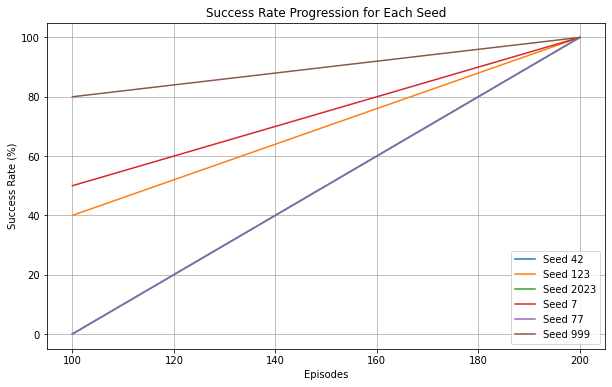

In [8]:

# ------------------------------------------------------------
# Training Loop with Multiple Seeds for Robustness
# ------------------------------------------------------------
if __name__ == "__main__":
    seeds = [42, 123, 2023, 7, 77, 999]  # Random seeds for robustness
    env_name = 'FetchReach-v3'
    max_training_episodes = 5000
    max_steps_per_episode = 50
    batch_size = 256
    eval_interval = 100
    num_eval_episodes = 10  # Number of evaluation episodes
    final_eval_episodes = 100  # Number of final evaluation episodes

    # To store success rates per episode for all seeds
    success_rate_per_episode = {seed: [] for seed in seeds}

    # To store final success rates across all seeds
    all_success_rates = []

    for seed in seeds:
        print(f"Running with seed: {seed}")

        # Create environment and set random seeds
        env = gym.make(env_name, max_episode_steps=max_steps_per_episode)
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

        # Extract dimensions of observations, goals, and actions
        observation_dim = env.reset()[0]['observation'].shape[0]
        goal_dim = env.reset()[0]['desired_goal'].shape[0]
        action_dim = env.action_space.shape[0]

        # Hyperparameters
        learning_rate = 3e-4
        discount_factor = 0.98
        soft_update_tau = 0.005
        temperature_alpha = 0.2
        buffer_capacity = 1_000_000
        her_future_k = 4
        her_sample_ratio = 0.8

        # Initialize SAC with HER agent
        sac_her_agent = SACWithHER(
            observation_dim, goal_dim, action_dim, lr=learning_rate, gamma=discount_factor,
            tau=soft_update_tau, alpha=temperature_alpha, buffer_capacity=buffer_capacity,
            her_future_k=her_future_k, her_ratio=her_sample_ratio, device='cuda'
        )

        # Training loop for the current seed
        for episode in range(max_training_episodes):
            # Reset the environment for a new episode
            obs_dict = env.reset()[0]
            current_obs, desired_goal = obs_dict['observation'], obs_dict['desired_goal']
            episode_memory = []
            episode_success = 0
            done = False

            for step in range(max_steps_per_episode):
                # Agent selects an action
                action = sac_her_agent.choose_action(current_obs, desired_goal, eval_mode=False)

                # Environment processes the action
                next_obs_dict, reward, terminated, truncated, info = env.step(action)
                next_obs = next_obs_dict['observation']
                done = terminated or truncated

                # Track success for this episode
                if info.get('is_success', 0.0) >= 0.5:
                    episode_success = 1

                # Store transition in memory
                episode_memory.append((current_obs, desired_goal, action, reward, next_obs, float(done)))
                current_obs = next_obs

                # Update the SAC agent's parameters
                sac_her_agent.update_networks(batch_size)

                if done:
                    break

            # Perform HER relabeling and store in buffer
            sac_her_agent.relabel_with_her(episode_memory)

            # Evaluate the agent periodically
            if (episode + 1) % eval_interval == 0:
                success_rate = evaluate_policy(sac_her_agent, env, num_episodes=num_eval_episodes, render_mode=False)
                success_rate_per_episode[seed].append((episode + 1, success_rate))
                print(f"Seed {seed}, Evaluation after {episode + 1} episodes: Success rate = {success_rate * 100:.2f}%")
                if success_rate >= 0.95:
                    print(f"Seed {seed}: Agent reached >95% success rate. Stopping training early.")
                    break

        # Final evaluation for the current seed
        final_success_rate = evaluate_policy(sac_her_agent, env, num_episodes=final_eval_episodes, render_mode=False)
        print(f"Seed {seed}: Final evaluation success rate = {final_success_rate * 100:.2f}%")
        all_success_rates.append(final_success_rate)

    # Compute and display average success rate across seeds
    avg_success_rate = np.mean(all_success_rates)
    print(f"Average success rate across seeds: {avg_success_rate * 100:.2f}%")

    # ------------------------------------------------------------
    # Plotting Success Rates
    # ------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    for seed, rates in success_rate_per_episode.items():
        episodes = [ep for ep, _ in rates]
        success_rates = [rate * 100 for _, rate in rates]
        plt.plot(episodes, success_rates, label=f'Seed {seed}')

    plt.xlabel('Episodes')
    plt.ylabel('Success Rate (%)')
    plt.title('Success Rate Progression for Each Seed')
    plt.legend()
    plt.grid()
    plt.show()


### VISUALIZE THE PROCESS WITH HUMAN RENDERING

In [8]:


def visualize(agent, env_name='FetchReach-v3', episodes=50, max_episode_steps=100, delay=0.1):
    """
    Visualizes the performance of the agent in the environment with a delay between steps.

    Args:
        agent: The trained SACWithHERAgent instance.
        env_name: Name of the Gym environment (e.g., 'FetchReach-v3').
        episodes: Number of episodes to visualize.
        max_episode_steps: Maximum steps per episode.
        delay: Time delay (in seconds) between each step for slowing down visualization.
    """
    # Create the environment in 'human' render mode
    env = gym.make(env_name, max_episode_steps=max_episode_steps, render_mode='human')

    for episode in range(episodes):
        obs_dict = env.reset()[0]
        obs, goal = obs_dict['observation'], obs_dict['desired_goal']
        done = False
        steps = 0

        print(f"Starting Episode {episode + 1}")
        while not done and steps < max_episode_steps:
            action = agent.choose_action(obs, goal, eval_mode=True)
            next_obs_dict, reward, terminated, truncated, info = env.step(action)
            obs = next_obs_dict['observation']
            done = terminated or truncated
            steps += 1

            # Optionally print debug information
            print(f"Step: {steps}, Reward: {reward}, Success: {info.get('is_success', 0.0)}")
            
            # Add delay between steps to slow down the visualization
            time.sleep(delay)

        print(f"Episode {episode + 1} ended. Success: {info.get('is_success', 0.0)}\n")

    env.close()

# Assuming the agent is trained and stored as `agent`, call the function:
visualize(sac_her_agent, delay=0.0)  # Adjust delay as desired (e.g., 0.5 seconds per step)

Starting Episode 1
Step: 1, Reward: -1.0, Success: 0.0
Step: 2, Reward: -1.0, Success: 0.0
Step: 3, Reward: -1.0, Success: 0.0
Step: 4, Reward: -1.0, Success: 0.0
Step: 5, Reward: -1.0, Success: 0.0
Step: 6, Reward: -1.0, Success: 0.0
Step: 7, Reward: -1.0, Success: 0.0
Step: 8, Reward: -1.0, Success: 0.0
Step: 9, Reward: -1.0, Success: 0.0
Step: 10, Reward: -1.0, Success: 0.0
Step: 11, Reward: -1.0, Success: 0.0
Step: 12, Reward: -1.0, Success: 0.0
Step: 13, Reward: -1.0, Success: 0.0
Step: 14, Reward: -1.0, Success: 0.0
Step: 15, Reward: -1.0, Success: 0.0
Step: 16, Reward: -0.0, Success: 1.0
Step: 17, Reward: -0.0, Success: 1.0
Step: 18, Reward: -0.0, Success: 1.0
Step: 19, Reward: -0.0, Success: 1.0
Step: 20, Reward: -0.0, Success: 1.0
Step: 21, Reward: -0.0, Success: 1.0
Step: 22, Reward: -0.0, Success: 1.0
Step: 23, Reward: -0.0, Success: 1.0
Step: 24, Reward: -0.0, Success: 1.0
Step: 25, Reward: -0.0, Success: 1.0
Step: 26, Reward: -0.0, Success: 1.0
Step: 27, Reward: -0.0, Succ

Step: 58, Reward: -0.0, Success: 1.0
Step: 59, Reward: -0.0, Success: 1.0
Step: 60, Reward: -0.0, Success: 1.0
Step: 61, Reward: -0.0, Success: 1.0
Step: 62, Reward: -0.0, Success: 1.0
Step: 63, Reward: -0.0, Success: 1.0
Step: 64, Reward: -0.0, Success: 1.0
Step: 65, Reward: -0.0, Success: 1.0
Step: 66, Reward: -0.0, Success: 1.0
Step: 67, Reward: -0.0, Success: 1.0
Step: 68, Reward: -0.0, Success: 1.0
Step: 69, Reward: -0.0, Success: 1.0
Step: 70, Reward: -0.0, Success: 1.0
Step: 71, Reward: -0.0, Success: 1.0
Step: 72, Reward: -0.0, Success: 1.0
Step: 73, Reward: -0.0, Success: 1.0
Step: 74, Reward: -0.0, Success: 1.0
Step: 75, Reward: -0.0, Success: 1.0
Step: 76, Reward: -0.0, Success: 1.0
Step: 77, Reward: -0.0, Success: 1.0
Step: 78, Reward: -0.0, Success: 1.0
Step: 79, Reward: -0.0, Success: 1.0
Step: 80, Reward: -0.0, Success: 1.0
Step: 81, Reward: -0.0, Success: 1.0
Step: 82, Reward: -0.0, Success: 1.0
Step: 83, Reward: -0.0, Success: 1.0
Step: 84, Reward: -0.0, Success: 1.0
S

Step: 96, Reward: -0.0, Success: 1.0
Step: 97, Reward: -0.0, Success: 1.0
Step: 98, Reward: -0.0, Success: 1.0
Step: 99, Reward: -0.0, Success: 1.0
Step: 100, Reward: -0.0, Success: 1.0
Episode 5 ended. Success: 1.0

Starting Episode 6
Step: 1, Reward: -1.0, Success: 0.0
Step: 2, Reward: -1.0, Success: 0.0
Step: 3, Reward: -1.0, Success: 0.0
Step: 4, Reward: -1.0, Success: 0.0
Step: 5, Reward: -1.0, Success: 0.0
Step: 6, Reward: -1.0, Success: 0.0
Step: 7, Reward: -1.0, Success: 0.0
Step: 8, Reward: -1.0, Success: 0.0
Step: 9, Reward: -1.0, Success: 0.0
Step: 10, Reward: -1.0, Success: 0.0
Step: 11, Reward: -1.0, Success: 0.0
Step: 12, Reward: -1.0, Success: 0.0
Step: 13, Reward: -1.0, Success: 0.0
Step: 14, Reward: -1.0, Success: 0.0
Step: 15, Reward: -0.0, Success: 1.0
Step: 16, Reward: -0.0, Success: 1.0
Step: 17, Reward: -0.0, Success: 1.0
Step: 18, Reward: -0.0, Success: 1.0
Step: 19, Reward: -0.0, Success: 1.0
Step: 20, Reward: -0.0, Success: 1.0
Step: 21, Reward: -0.0, Success: 

Step: 41, Reward: -0.0, Success: 1.0
Step: 42, Reward: -0.0, Success: 1.0
Step: 43, Reward: -0.0, Success: 1.0
Step: 44, Reward: -0.0, Success: 1.0
Step: 45, Reward: -0.0, Success: 1.0
Step: 46, Reward: -0.0, Success: 1.0
Step: 47, Reward: -0.0, Success: 1.0
Step: 48, Reward: -0.0, Success: 1.0
Step: 49, Reward: -0.0, Success: 1.0
Step: 50, Reward: -0.0, Success: 1.0
Step: 51, Reward: -0.0, Success: 1.0
Step: 52, Reward: -0.0, Success: 1.0
Step: 53, Reward: -0.0, Success: 1.0
Step: 54, Reward: -0.0, Success: 1.0
Step: 55, Reward: -0.0, Success: 1.0
Step: 56, Reward: -0.0, Success: 1.0
Step: 57, Reward: -0.0, Success: 1.0
Step: 58, Reward: -0.0, Success: 1.0
Step: 59, Reward: -0.0, Success: 1.0
Step: 60, Reward: -0.0, Success: 1.0
Step: 61, Reward: -0.0, Success: 1.0
Step: 62, Reward: -0.0, Success: 1.0
Step: 63, Reward: -0.0, Success: 1.0
Step: 64, Reward: -0.0, Success: 1.0
Step: 65, Reward: -0.0, Success: 1.0
Step: 66, Reward: -0.0, Success: 1.0
Step: 67, Reward: -0.0, Success: 1.0
S

Step: 70, Reward: -0.0, Success: 1.0
Step: 71, Reward: -0.0, Success: 1.0
Step: 72, Reward: -0.0, Success: 1.0
Step: 73, Reward: -0.0, Success: 1.0
Step: 74, Reward: -0.0, Success: 1.0
Step: 75, Reward: -0.0, Success: 1.0
Step: 76, Reward: -0.0, Success: 1.0
Step: 77, Reward: -0.0, Success: 1.0
Step: 78, Reward: -0.0, Success: 1.0
Step: 79, Reward: -0.0, Success: 1.0
Step: 80, Reward: -0.0, Success: 1.0
Step: 81, Reward: -0.0, Success: 1.0
Step: 82, Reward: -0.0, Success: 1.0
Step: 83, Reward: -0.0, Success: 1.0
Step: 84, Reward: -0.0, Success: 1.0
Step: 85, Reward: -0.0, Success: 1.0
Step: 86, Reward: -0.0, Success: 1.0
Step: 87, Reward: -0.0, Success: 1.0
Step: 88, Reward: -0.0, Success: 1.0
Step: 89, Reward: -0.0, Success: 1.0
Step: 90, Reward: -0.0, Success: 1.0
Step: 91, Reward: -0.0, Success: 1.0
Step: 92, Reward: -0.0, Success: 1.0
Step: 93, Reward: -0.0, Success: 1.0
Step: 94, Reward: -0.0, Success: 1.0
Step: 95, Reward: -0.0, Success: 1.0
Step: 96, Reward: -0.0, Success: 1.0
S

Step: 95, Reward: -0.0, Success: 1.0
Step: 96, Reward: -0.0, Success: 1.0
Step: 97, Reward: -0.0, Success: 1.0
Step: 98, Reward: -0.0, Success: 1.0
Step: 99, Reward: -0.0, Success: 1.0
Step: 100, Reward: -0.0, Success: 1.0
Episode 12 ended. Success: 1.0

Starting Episode 13
Step: 1, Reward: -1.0, Success: 0.0
Step: 2, Reward: -1.0, Success: 0.0
Step: 3, Reward: -1.0, Success: 0.0
Step: 4, Reward: -1.0, Success: 0.0
Step: 5, Reward: -1.0, Success: 0.0
Step: 6, Reward: -1.0, Success: 0.0
Step: 7, Reward: -1.0, Success: 0.0
Step: 8, Reward: -1.0, Success: 0.0
Step: 9, Reward: -1.0, Success: 0.0
Step: 10, Reward: -1.0, Success: 0.0
Step: 11, Reward: -1.0, Success: 0.0
Step: 12, Reward: -1.0, Success: 0.0
Step: 13, Reward: -1.0, Success: 0.0
Step: 14, Reward: -1.0, Success: 0.0
Step: 15, Reward: -1.0, Success: 0.0
Step: 16, Reward: -1.0, Success: 0.0
Step: 17, Reward: -1.0, Success: 0.0
Step: 18, Reward: -1.0, Success: 0.0
Step: 19, Reward: -1.0, Success: 0.0
Step: 20, Reward: -0.0, Success

Step: 15, Reward: -1.0, Success: 0.0
Step: 16, Reward: -0.0, Success: 1.0
Step: 17, Reward: -0.0, Success: 1.0
Step: 18, Reward: -0.0, Success: 1.0
Step: 19, Reward: -0.0, Success: 1.0
Step: 20, Reward: -0.0, Success: 1.0
Step: 21, Reward: -0.0, Success: 1.0
Step: 22, Reward: -0.0, Success: 1.0
Step: 23, Reward: -0.0, Success: 1.0
Step: 24, Reward: -0.0, Success: 1.0
Step: 25, Reward: -0.0, Success: 1.0
Step: 26, Reward: -0.0, Success: 1.0
Step: 27, Reward: -0.0, Success: 1.0
Step: 28, Reward: -0.0, Success: 1.0
Step: 29, Reward: -0.0, Success: 1.0
Step: 30, Reward: -0.0, Success: 1.0
Step: 31, Reward: -0.0, Success: 1.0
Step: 32, Reward: -0.0, Success: 1.0
Step: 33, Reward: -0.0, Success: 1.0
Step: 34, Reward: -0.0, Success: 1.0
Step: 35, Reward: -0.0, Success: 1.0
Step: 36, Reward: -0.0, Success: 1.0
Step: 37, Reward: -0.0, Success: 1.0
Step: 38, Reward: -0.0, Success: 1.0
Step: 39, Reward: -0.0, Success: 1.0
Step: 40, Reward: -0.0, Success: 1.0
Step: 41, Reward: -0.0, Success: 1.0
S

Step: 36, Reward: -0.0, Success: 1.0
Step: 37, Reward: -0.0, Success: 1.0
Step: 38, Reward: -0.0, Success: 1.0
Step: 39, Reward: -0.0, Success: 1.0
Step: 40, Reward: -0.0, Success: 1.0
Step: 41, Reward: -0.0, Success: 1.0
Step: 42, Reward: -0.0, Success: 1.0
Step: 43, Reward: -0.0, Success: 1.0
Step: 44, Reward: -0.0, Success: 1.0
Step: 45, Reward: -0.0, Success: 1.0
Step: 46, Reward: -0.0, Success: 1.0
Step: 47, Reward: -0.0, Success: 1.0
Step: 48, Reward: -0.0, Success: 1.0
Step: 49, Reward: -0.0, Success: 1.0
Step: 50, Reward: -0.0, Success: 1.0
Step: 51, Reward: -0.0, Success: 1.0
Step: 52, Reward: -0.0, Success: 1.0
Step: 53, Reward: -0.0, Success: 1.0
Step: 54, Reward: -0.0, Success: 1.0
Step: 55, Reward: -0.0, Success: 1.0
Step: 56, Reward: -0.0, Success: 1.0
Step: 57, Reward: -0.0, Success: 1.0
Step: 58, Reward: -0.0, Success: 1.0
Step: 59, Reward: -0.0, Success: 1.0
Step: 60, Reward: -0.0, Success: 1.0
Step: 61, Reward: -0.0, Success: 1.0
Step: 62, Reward: -0.0, Success: 1.0
S

Step: 59, Reward: -0.0, Success: 1.0
Step: 60, Reward: -0.0, Success: 1.0
Step: 61, Reward: -0.0, Success: 1.0
Step: 62, Reward: -0.0, Success: 1.0
Step: 63, Reward: -0.0, Success: 1.0
Step: 64, Reward: -0.0, Success: 1.0
Step: 65, Reward: -0.0, Success: 1.0
Step: 66, Reward: -0.0, Success: 1.0
Step: 67, Reward: -0.0, Success: 1.0
Step: 68, Reward: -0.0, Success: 1.0
Step: 69, Reward: -0.0, Success: 1.0
Step: 70, Reward: -0.0, Success: 1.0
Step: 71, Reward: -0.0, Success: 1.0
Step: 72, Reward: -0.0, Success: 1.0
Step: 73, Reward: -0.0, Success: 1.0
Step: 74, Reward: -0.0, Success: 1.0
Step: 75, Reward: -0.0, Success: 1.0
Step: 76, Reward: -0.0, Success: 1.0
Step: 77, Reward: -0.0, Success: 1.0
Step: 78, Reward: -0.0, Success: 1.0
Step: 79, Reward: -0.0, Success: 1.0
Step: 80, Reward: -0.0, Success: 1.0
Step: 81, Reward: -0.0, Success: 1.0
Step: 82, Reward: -0.0, Success: 1.0
Step: 83, Reward: -0.0, Success: 1.0
Step: 84, Reward: -0.0, Success: 1.0
Step: 85, Reward: -0.0, Success: 1.0
S

Step: 9, Reward: -1.0, Success: 0.0
Step: 10, Reward: -1.0, Success: 0.0
Step: 11, Reward: -1.0, Success: 0.0
Step: 12, Reward: -1.0, Success: 0.0
Step: 13, Reward: -1.0, Success: 0.0
Step: 14, Reward: -1.0, Success: 0.0
Step: 15, Reward: -1.0, Success: 0.0
Step: 16, Reward: -1.0, Success: 0.0
Step: 17, Reward: -1.0, Success: 0.0
Step: 18, Reward: -1.0, Success: 0.0
Step: 19, Reward: -1.0, Success: 0.0
Step: 20, Reward: -1.0, Success: 0.0
Step: 21, Reward: -0.0, Success: 1.0
Step: 22, Reward: -0.0, Success: 1.0
Step: 23, Reward: -0.0, Success: 1.0
Step: 24, Reward: -0.0, Success: 1.0
Step: 25, Reward: -0.0, Success: 1.0
Step: 26, Reward: -0.0, Success: 1.0
Step: 27, Reward: -0.0, Success: 1.0
Step: 28, Reward: -0.0, Success: 1.0
Step: 29, Reward: -0.0, Success: 1.0
Step: 30, Reward: -0.0, Success: 1.0
Step: 31, Reward: -0.0, Success: 1.0
Step: 32, Reward: -0.0, Success: 1.0
Step: 33, Reward: -0.0, Success: 1.0
Step: 34, Reward: -0.0, Success: 1.0
Step: 35, Reward: -0.0, Success: 1.0
St

Step: 60, Reward: -0.0, Success: 1.0
Step: 61, Reward: -0.0, Success: 1.0
Step: 62, Reward: -0.0, Success: 1.0
Step: 63, Reward: -0.0, Success: 1.0
Step: 64, Reward: -0.0, Success: 1.0
Step: 65, Reward: -0.0, Success: 1.0
Step: 66, Reward: -0.0, Success: 1.0
Step: 67, Reward: -0.0, Success: 1.0
Step: 68, Reward: -0.0, Success: 1.0
Step: 69, Reward: -0.0, Success: 1.0
Step: 70, Reward: -0.0, Success: 1.0
Step: 71, Reward: -0.0, Success: 1.0
Step: 72, Reward: -0.0, Success: 1.0
Step: 73, Reward: -0.0, Success: 1.0
Step: 74, Reward: -0.0, Success: 1.0
Step: 75, Reward: -0.0, Success: 1.0
Step: 76, Reward: -0.0, Success: 1.0
Step: 77, Reward: -0.0, Success: 1.0
Step: 78, Reward: -0.0, Success: 1.0
Step: 79, Reward: -0.0, Success: 1.0
Step: 80, Reward: -0.0, Success: 1.0
Step: 81, Reward: -0.0, Success: 1.0
Step: 82, Reward: -0.0, Success: 1.0
Step: 83, Reward: -0.0, Success: 1.0
Step: 84, Reward: -0.0, Success: 1.0
Step: 85, Reward: -0.0, Success: 1.0
Step: 86, Reward: -0.0, Success: 1.0
S

Step: 80, Reward: -0.0, Success: 1.0
Step: 81, Reward: -0.0, Success: 1.0
Step: 82, Reward: -0.0, Success: 1.0
Step: 83, Reward: -0.0, Success: 1.0
Step: 84, Reward: -0.0, Success: 1.0
Step: 85, Reward: -0.0, Success: 1.0
Step: 86, Reward: -0.0, Success: 1.0
Step: 87, Reward: -0.0, Success: 1.0
Step: 88, Reward: -0.0, Success: 1.0
Step: 89, Reward: -0.0, Success: 1.0
Step: 90, Reward: -0.0, Success: 1.0
Step: 91, Reward: -0.0, Success: 1.0
Step: 92, Reward: -0.0, Success: 1.0
Step: 93, Reward: -0.0, Success: 1.0
Step: 94, Reward: -0.0, Success: 1.0
Step: 95, Reward: -0.0, Success: 1.0
Step: 96, Reward: -0.0, Success: 1.0
Step: 97, Reward: -0.0, Success: 1.0
Step: 98, Reward: -0.0, Success: 1.0
Step: 99, Reward: -0.0, Success: 1.0
Step: 100, Reward: -0.0, Success: 1.0
Episode 26 ended. Success: 1.0

Starting Episode 27
Step: 1, Reward: -1.0, Success: 0.0
Step: 2, Reward: -1.0, Success: 0.0
Step: 3, Reward: -1.0, Success: 0.0
Step: 4, Reward: -1.0, Success: 0.0
Step: 5, Reward: -1.0, Suc

Step: 25, Reward: -0.0, Success: 1.0
Step: 26, Reward: -0.0, Success: 1.0
Step: 27, Reward: -0.0, Success: 1.0
Step: 28, Reward: -0.0, Success: 1.0
Step: 29, Reward: -0.0, Success: 1.0
Step: 30, Reward: -0.0, Success: 1.0
Step: 31, Reward: -0.0, Success: 1.0
Step: 32, Reward: -0.0, Success: 1.0
Step: 33, Reward: -0.0, Success: 1.0
Step: 34, Reward: -0.0, Success: 1.0
Step: 35, Reward: -0.0, Success: 1.0
Step: 36, Reward: -0.0, Success: 1.0
Step: 37, Reward: -0.0, Success: 1.0
Step: 38, Reward: -0.0, Success: 1.0
Step: 39, Reward: -0.0, Success: 1.0
Step: 40, Reward: -0.0, Success: 1.0
Step: 41, Reward: -0.0, Success: 1.0
Step: 42, Reward: -0.0, Success: 1.0
Step: 43, Reward: -0.0, Success: 1.0
Step: 44, Reward: -0.0, Success: 1.0
Step: 45, Reward: -0.0, Success: 1.0
Step: 46, Reward: -0.0, Success: 1.0
Step: 47, Reward: -0.0, Success: 1.0
Step: 48, Reward: -0.0, Success: 1.0
Step: 49, Reward: -0.0, Success: 1.0
Step: 50, Reward: -0.0, Success: 1.0
Step: 51, Reward: -0.0, Success: 1.0
S

Step: 80, Reward: -0.0, Success: 1.0
Step: 81, Reward: -0.0, Success: 1.0
Step: 82, Reward: -0.0, Success: 1.0
Step: 83, Reward: -0.0, Success: 1.0
Step: 84, Reward: -0.0, Success: 1.0
Step: 85, Reward: -0.0, Success: 1.0
Step: 86, Reward: -0.0, Success: 1.0
Step: 87, Reward: -0.0, Success: 1.0
Step: 88, Reward: -0.0, Success: 1.0
Step: 89, Reward: -0.0, Success: 1.0
Step: 90, Reward: -0.0, Success: 1.0
Step: 91, Reward: -0.0, Success: 1.0
Step: 92, Reward: -0.0, Success: 1.0
Step: 93, Reward: -0.0, Success: 1.0
Step: 94, Reward: -0.0, Success: 1.0
Step: 95, Reward: -0.0, Success: 1.0
Step: 96, Reward: -0.0, Success: 1.0
Step: 97, Reward: -0.0, Success: 1.0
Step: 98, Reward: -0.0, Success: 1.0
Step: 99, Reward: -0.0, Success: 1.0
Step: 100, Reward: -0.0, Success: 1.0
Episode 31 ended. Success: 1.0

Starting Episode 32
Step: 1, Reward: -1.0, Success: 0.0
Step: 2, Reward: -1.0, Success: 0.0
Step: 3, Reward: -1.0, Success: 0.0
Step: 4, Reward: -1.0, Success: 0.0
Step: 5, Reward: -1.0, Suc

Step: 1, Reward: -1.0, Success: 0.0
Step: 2, Reward: -1.0, Success: 0.0
Step: 3, Reward: -1.0, Success: 0.0
Step: 4, Reward: -1.0, Success: 0.0
Step: 5, Reward: -1.0, Success: 0.0
Step: 6, Reward: -1.0, Success: 0.0
Step: 7, Reward: -1.0, Success: 0.0
Step: 8, Reward: -1.0, Success: 0.0
Step: 9, Reward: -1.0, Success: 0.0
Step: 10, Reward: -1.0, Success: 0.0
Step: 11, Reward: -1.0, Success: 0.0
Step: 12, Reward: -0.0, Success: 1.0
Step: 13, Reward: -0.0, Success: 1.0
Step: 14, Reward: -0.0, Success: 1.0
Step: 15, Reward: -0.0, Success: 1.0
Step: 16, Reward: -0.0, Success: 1.0
Step: 17, Reward: -0.0, Success: 1.0
Step: 18, Reward: -0.0, Success: 1.0
Step: 19, Reward: -0.0, Success: 1.0
Step: 20, Reward: -0.0, Success: 1.0
Step: 21, Reward: -0.0, Success: 1.0
Step: 22, Reward: -0.0, Success: 1.0
Step: 23, Reward: -0.0, Success: 1.0
Step: 24, Reward: -0.0, Success: 1.0
Step: 25, Reward: -0.0, Success: 1.0
Step: 26, Reward: -0.0, Success: 1.0
Step: 27, Reward: -0.0, Success: 1.0
Step: 28, 

Step: 26, Reward: -0.0, Success: 1.0
Step: 27, Reward: -0.0, Success: 1.0
Step: 28, Reward: -0.0, Success: 1.0
Step: 29, Reward: -0.0, Success: 1.0
Step: 30, Reward: -0.0, Success: 1.0
Step: 31, Reward: -0.0, Success: 1.0
Step: 32, Reward: -0.0, Success: 1.0
Step: 33, Reward: -0.0, Success: 1.0
Step: 34, Reward: -0.0, Success: 1.0
Step: 35, Reward: -0.0, Success: 1.0
Step: 36, Reward: -0.0, Success: 1.0
Step: 37, Reward: -0.0, Success: 1.0
Step: 38, Reward: -0.0, Success: 1.0
Step: 39, Reward: -0.0, Success: 1.0
Step: 40, Reward: -0.0, Success: 1.0
Step: 41, Reward: -0.0, Success: 1.0
Step: 42, Reward: -0.0, Success: 1.0
Step: 43, Reward: -0.0, Success: 1.0
Step: 44, Reward: -0.0, Success: 1.0
Step: 45, Reward: -0.0, Success: 1.0
Step: 46, Reward: -0.0, Success: 1.0
Step: 47, Reward: -0.0, Success: 1.0
Step: 48, Reward: -0.0, Success: 1.0
Step: 49, Reward: -0.0, Success: 1.0
Step: 50, Reward: -0.0, Success: 1.0
Step: 51, Reward: -0.0, Success: 1.0
Step: 52, Reward: -0.0, Success: 1.0
S

Step: 53, Reward: -0.0, Success: 1.0
Step: 54, Reward: -0.0, Success: 1.0
Step: 55, Reward: -0.0, Success: 1.0
Step: 56, Reward: -0.0, Success: 1.0
Step: 57, Reward: -0.0, Success: 1.0
Step: 58, Reward: -0.0, Success: 1.0
Step: 59, Reward: -0.0, Success: 1.0
Step: 60, Reward: -0.0, Success: 1.0
Step: 61, Reward: -0.0, Success: 1.0
Step: 62, Reward: -0.0, Success: 1.0
Step: 63, Reward: -0.0, Success: 1.0
Step: 64, Reward: -0.0, Success: 1.0
Step: 65, Reward: -0.0, Success: 1.0
Step: 66, Reward: -0.0, Success: 1.0
Step: 67, Reward: -0.0, Success: 1.0
Step: 68, Reward: -0.0, Success: 1.0
Step: 69, Reward: -0.0, Success: 1.0
Step: 70, Reward: -0.0, Success: 1.0
Step: 71, Reward: -0.0, Success: 1.0
Step: 72, Reward: -0.0, Success: 1.0
Step: 73, Reward: -0.0, Success: 1.0
Step: 74, Reward: -0.0, Success: 1.0
Step: 75, Reward: -0.0, Success: 1.0
Step: 76, Reward: -0.0, Success: 1.0
Step: 77, Reward: -0.0, Success: 1.0
Step: 78, Reward: -0.0, Success: 1.0
Step: 79, Reward: -0.0, Success: 1.0
S

Step: 79, Reward: -0.0, Success: 1.0
Step: 80, Reward: -0.0, Success: 1.0
Step: 81, Reward: -0.0, Success: 1.0
Step: 82, Reward: -0.0, Success: 1.0
Step: 83, Reward: -0.0, Success: 1.0
Step: 84, Reward: -0.0, Success: 1.0
Step: 85, Reward: -0.0, Success: 1.0
Step: 86, Reward: -0.0, Success: 1.0
Step: 87, Reward: -0.0, Success: 1.0
Step: 88, Reward: -0.0, Success: 1.0
Step: 89, Reward: -0.0, Success: 1.0
Step: 90, Reward: -0.0, Success: 1.0
Step: 91, Reward: -0.0, Success: 1.0
Step: 92, Reward: -0.0, Success: 1.0
Step: 93, Reward: -0.0, Success: 1.0
Step: 94, Reward: -0.0, Success: 1.0
Step: 95, Reward: -0.0, Success: 1.0
Step: 96, Reward: -0.0, Success: 1.0
Step: 97, Reward: -0.0, Success: 1.0
Step: 98, Reward: -0.0, Success: 1.0
Step: 99, Reward: -0.0, Success: 1.0
Step: 100, Reward: -0.0, Success: 1.0
Episode 40 ended. Success: 1.0

Starting Episode 41
Step: 1, Reward: -1.0, Success: 0.0
Step: 2, Reward: -1.0, Success: 0.0
Step: 3, Reward: -1.0, Success: 0.0
Step: 4, Reward: -1.0, Su

Step: 20, Reward: -1.0, Success: 0.0
Step: 21, Reward: -1.0, Success: 0.0
Step: 22, Reward: -1.0, Success: 0.0
Step: 23, Reward: -0.0, Success: 1.0
Step: 24, Reward: -0.0, Success: 1.0
Step: 25, Reward: -0.0, Success: 1.0
Step: 26, Reward: -0.0, Success: 1.0
Step: 27, Reward: -0.0, Success: 1.0
Step: 28, Reward: -0.0, Success: 1.0
Step: 29, Reward: -0.0, Success: 1.0
Step: 30, Reward: -0.0, Success: 1.0
Step: 31, Reward: -0.0, Success: 1.0
Step: 32, Reward: -0.0, Success: 1.0
Step: 33, Reward: -0.0, Success: 1.0
Step: 34, Reward: -0.0, Success: 1.0
Step: 35, Reward: -0.0, Success: 1.0
Step: 36, Reward: -0.0, Success: 1.0
Step: 37, Reward: -0.0, Success: 1.0
Step: 38, Reward: -0.0, Success: 1.0
Step: 39, Reward: -0.0, Success: 1.0
Step: 40, Reward: -0.0, Success: 1.0
Step: 41, Reward: -0.0, Success: 1.0
Step: 42, Reward: -0.0, Success: 1.0
Step: 43, Reward: -0.0, Success: 1.0
Step: 44, Reward: -0.0, Success: 1.0
Step: 45, Reward: -0.0, Success: 1.0
Step: 46, Reward: -0.0, Success: 1.0
S

Step: 44, Reward: -0.0, Success: 1.0
Step: 45, Reward: -0.0, Success: 1.0
Step: 46, Reward: -0.0, Success: 1.0
Step: 47, Reward: -0.0, Success: 1.0
Step: 48, Reward: -0.0, Success: 1.0
Step: 49, Reward: -0.0, Success: 1.0
Step: 50, Reward: -0.0, Success: 1.0
Step: 51, Reward: -0.0, Success: 1.0
Step: 52, Reward: -0.0, Success: 1.0
Step: 53, Reward: -0.0, Success: 1.0
Step: 54, Reward: -0.0, Success: 1.0
Step: 55, Reward: -0.0, Success: 1.0
Step: 56, Reward: -0.0, Success: 1.0
Step: 57, Reward: -0.0, Success: 1.0
Step: 58, Reward: -0.0, Success: 1.0
Step: 59, Reward: -0.0, Success: 1.0
Step: 60, Reward: -0.0, Success: 1.0
Step: 61, Reward: -0.0, Success: 1.0
Step: 62, Reward: -0.0, Success: 1.0
Step: 63, Reward: -0.0, Success: 1.0
Step: 64, Reward: -0.0, Success: 1.0
Step: 65, Reward: -0.0, Success: 1.0
Step: 66, Reward: -0.0, Success: 1.0
Step: 67, Reward: -0.0, Success: 1.0
Step: 68, Reward: -0.0, Success: 1.0
Step: 69, Reward: -0.0, Success: 1.0
Step: 70, Reward: -0.0, Success: 1.0
S

Step: 69, Reward: -0.0, Success: 1.0
Step: 70, Reward: -0.0, Success: 1.0
Step: 71, Reward: -0.0, Success: 1.0
Step: 72, Reward: -0.0, Success: 1.0
Step: 73, Reward: -0.0, Success: 1.0
Step: 74, Reward: -0.0, Success: 1.0
Step: 75, Reward: -0.0, Success: 1.0
Step: 76, Reward: -0.0, Success: 1.0
Step: 77, Reward: -0.0, Success: 1.0
Step: 78, Reward: -0.0, Success: 1.0
Step: 79, Reward: -0.0, Success: 1.0
Step: 80, Reward: -0.0, Success: 1.0
Step: 81, Reward: -0.0, Success: 1.0
Step: 82, Reward: -0.0, Success: 1.0
Step: 83, Reward: -0.0, Success: 1.0
Step: 84, Reward: -0.0, Success: 1.0
Step: 85, Reward: -0.0, Success: 1.0
Step: 86, Reward: -0.0, Success: 1.0
Step: 87, Reward: -0.0, Success: 1.0
Step: 88, Reward: -0.0, Success: 1.0
Step: 89, Reward: -0.0, Success: 1.0
Step: 90, Reward: -0.0, Success: 1.0
Step: 91, Reward: -0.0, Success: 1.0
Step: 92, Reward: -0.0, Success: 1.0
Step: 93, Reward: -0.0, Success: 1.0
Step: 94, Reward: -0.0, Success: 1.0
Step: 95, Reward: -0.0, Success: 1.0
S

Step: 89, Reward: -0.0, Success: 1.0
Step: 90, Reward: -0.0, Success: 1.0
Step: 91, Reward: -0.0, Success: 1.0
Step: 92, Reward: -0.0, Success: 1.0
Step: 93, Reward: -0.0, Success: 1.0
Step: 94, Reward: -0.0, Success: 1.0
Step: 95, Reward: -0.0, Success: 1.0
Step: 96, Reward: -0.0, Success: 1.0
Step: 97, Reward: -0.0, Success: 1.0
Step: 98, Reward: -0.0, Success: 1.0
Step: 99, Reward: -0.0, Success: 1.0
Step: 100, Reward: -0.0, Success: 1.0
Episode 49 ended. Success: 1.0

Starting Episode 50
Step: 1, Reward: -1.0, Success: 0.0
Step: 2, Reward: -1.0, Success: 0.0
Step: 3, Reward: -1.0, Success: 0.0
Step: 4, Reward: -1.0, Success: 0.0
Step: 5, Reward: -1.0, Success: 0.0
Step: 6, Reward: -1.0, Success: 0.0
Step: 7, Reward: -1.0, Success: 0.0
Step: 8, Reward: -1.0, Success: 0.0
Step: 9, Reward: -1.0, Success: 0.0
Step: 10, Reward: -1.0, Success: 0.0
Step: 11, Reward: -1.0, Success: 0.0
Step: 12, Reward: -1.0, Success: 0.0
Step: 13, Reward: -1.0, Success: 0.0
Step: 14, Reward: -1.0, Success